# Monte Carlo calculation of volumes and areas 

This notebook contains the Monte Carlo (MC) calculations of volumes and areas for the problem of two spheres ( 3d "discs") in a hard box.

In [1]:
using Distributions, Plots

┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1273
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273


In [2]:
h1 = 1
h2 = 1.5
h3 = 1.75

1.75

Exact analytical expressions derived in the paper:

In [3]:

# esta es otra hjay que cambiarla
cte = 3π/2   # E = 1/2 => abs(v^2) = 1 
sr2= sqrt(2)

# Esto puede no ser valido para 3d
# de hecho ninguno de estos aplica para 3D!
rhmax = h1/4  # maximum radius for which horizontal hop possible
rvmax = h2/4  # maximum radius for which vertical hop possible
rpmax = h3/4  
#rmax = ( h + w - √(2*h*w) ) / 2   # maximum possible radius for discs

volBox(a1, a2, a3) = 64 *a1^2*a2^2*a3^2
volNegfree(a1, a2, a3, r) = 64* ( (sr2*r)^3*π/6*a1*a2*a3*sr2^3
                            -(sr2*r)^4/16*π*(a1*a2+a2*a3+a3*a1)*sr2^2
                            +(sr2*r)^5/15*(a1+a2+a3)*sr2
                            -(sr2*r)^6/48)


# The neg volume is much much smaller than the full box
# in order to appreciate errors, we shall thest ONLY the neg volume
function vol(a, b, c, r)
    #result = volBox(a, b, c) - volNegfree(a, b, c, r)
    result =  volNegfree(a, b, c, r)
    
    return result
end 

vol (generic function with 1 method)

In [4]:
testvolneg(r)=volNegfree(h1/2-r, h2/2-r, h3/2-r,r)
testvolbox(r)=volBox(h1/2-r, h2/2-r, h3/2-r)

testvolbox (generic function with 1 method)

In [5]:
rangsr=0:0.01:0.285
volxul=map(testvolneg, rangsr);
volb=map(testvolbox, rangsr);

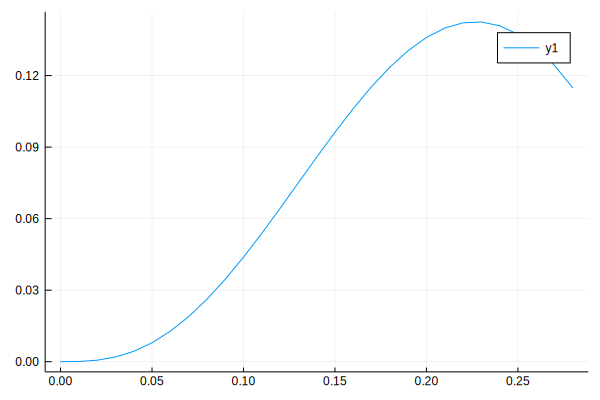

In [6]:
plot(rangsr, volxul)
#plot!(rangsr, volb)

In [7]:
"Available volume in configuration space"
function MC_volume(a, b, c, r, N=10^7)

    valid = 0
    
    for n in 1:N
        x1, x2 = rand(Uniform(-a, a), 2)
        y1, y2 = rand(Uniform(-b, b), 2)
        z1, z2 = rand(Uniform(-c, c), 2)
        ## Test ONLY negated Volume, not avaible Volume
        if (x1-x2)^2 + (y1-y2)^2 +(z1-z2)^2  <= (2r)^2  # non-overlapping condition
            valid += 1
        end
    end
    
    p = valid / N
    σ² = p * (1 - p) / N   # estimated variance of binomial distribution
    σ = √(σ²)
    vbox=volBox(a,b,c)
    
    return ( vbox * p, vbox * σ )
    
end

MC_volume

In [8]:
volprop3d=MC_volume(1,1,1,0.5)

(17.6890304, 0.009050945525788319)

In [9]:
"Area for horizontal hopping in configuration space"
function MC_horiz_hop_area3D(a, b, c, r, N=10^7, ϵ=0.001)
    
    valid = 0
    
    for n in 1:N
        x1, x2 = rand(Uniform(-a, a), 2)
        y1, y2 = rand(Uniform(-b, b), 2)
        z1, z2 = rand(Uniform(-c, c), 2)
        
        if (x1 - x2)^2 + (y1 - y2)^2 + (z1-z2)^2 < (2r)^2   # overlapping for testing first
            
            if abs(x1 - x2) < (ϵ * √2)  # horizontal hopping condition; factor √2 from diagonal orientation
                valid += 1
            end
        end
    end
    
    p = valid / N
    σ² = p * (1 - p) / N
    σ = √(σ²)
    vbox=volBox(a,b,c)
    
    return ( vbox * p / (2ϵ), (vbox  * σ) / (2ϵ) )   # factor of 2 since area is "2-sided"
end

MC_horiz_hop_area3D

In [35]:
 """ Area for collitions Monte Carlo"""

function MC_collision_area3D(a, b, c, r, N=10^7, ϵ=1e-3)
    
    valid = 0
    
    for n in 1:N
        x1, x2 = rand(Uniform(-a, a), 2)
        y1, y2 = rand(Uniform(-b, b), 2)
        z1, z2 = rand(Uniform(-c, c), 2)
        
        ρ = √( (x1 - x2)^2 + (y1 - y2)^2 + (z1 - z2)^2)
        
        if  0 < ρ - 2r < (ϵ)   
            valid += 1
        end
    end
    
    p = valid / N
    σ² = p * (1 - p) / N
    σ = √(σ²)
    vbox=volBox(a,b,c)
    
    return ( vbox * p) / ϵ,  ((vbox * σ) / ϵ )
end


MC_collision_area3D (generic function with 3 methods)

In [36]:
#= Esta no la has corregido para 3D


function MC_wall_area(a, b, r, N=10^7, ϵ=1e-3)
        
    valid = 0
    
    for n in 1:N
        x1, x2 = rand(Uniform(-a, a), 2)
        y1, y2 = rand(Uniform(-b, b), 2)
        
        if  (x1 - x2)^2 + (y1 - y2)^2 > (2*r)^2   # non-overlapping condition
         
            if a - ϵ < x1 < a  # collision of disc 1 with right wall
                valid += 1
            end
            
        end
    end
    
    p = valid / N
    σ² = p * (1 - p) / N
    σ = √(σ²)
    
    return ( (16a^2 * b^2 * p) / ϵ, (16a^2 * b^2 * σ ) / ϵ )
end
=#

## Generic MC function

In [37]:
function run_MC(MC_func, exact_func, rmax, N=10^6)
    h1, h2, h3 = 1.5, 1.2, 1

    numerical_data = Float64[]
    sigma_data = Float64[]  # standard deviation
    exact_data = Float64[]

    rs = Float64.(0.01:0.005:rmax)

    for r in rs

        print(r, " ")

        a = h1/2 - r
        b = h2/2 - r
        c=  h3/2 -r
        
        μ, σ =  MC_func(a, b, c, r, N)

        push!(numerical_data, μ)
        push!(sigma_data, σ)
        push!(exact_data, exact_func(a, b,c, r))
    end
    
    return rs, numerical_data, sigma_data, exact_data
end

run_MC (generic function with 2 methods)

## MC calculation of free volume

In [38]:
rs, numerical_V_data, sigma_V_data, exact_V_data = run_MC(MC_volume, vol, 0.25)

0.01 0.015 0.02 0.025 0.03 0.035 0.04 0.045 0.05 0.055 0.06 0.065 0.07 0.075 0.08 0.085 0.09 0.095 0.1 0.105 0.11 0.115 0.12 0.125 0.13 0.135 0.14 0.145 0.15 0.155 0.16 0.165 0.17 0.175 0.18 0.185 0.19 0.195 0.2 0.205 0.21 0.215 0.22 0.225 0.23 0.235 0.24 0.245 0.25 

([0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055  …  0.205, 0.21, 0.215, 0.22, 0.225, 0.23, 0.235, 0.24, 0.245, 0.25], [4.100790969497599e-5, 0.00019204320808682092, 0.00044409249909964783, 0.0008030246449999999, 0.0013120246451036157, 0.002084474372281586, 0.0030443037678305274, 0.003850021684701736, 0.005203978163999998, 0.006718573187184092  …  0.07361585867807004, 0.07375225102568297, 0.07367419402224099, 0.07319485300260048, 0.07261102243828126, 0.07171888911387035, 0.0703515506530489, 0.06885222556900147, 0.06722367973008661, 0.0651086275], [1.09597481542692e-5, 2.3118487805752983e-5, 3.425960198283552e-5, 4.488325930022598e-5, 5.587872811928968e-5, 6.85796382706495e-5, 8.067318138051706e-5, 8.828817395349089e-5, 9.984858460889643e-5, 0.00011032298042043554  …  0.0001165417237458242, 0.00011030367557356571, 0.00010402232647392648, 9.76698525765714e-5, 9.137433274243102e-5, 8.510566762559007e-5, 7.88862240835049e-5, 7.280571759533135e-5, 6.687502075188285e-5, 6.11

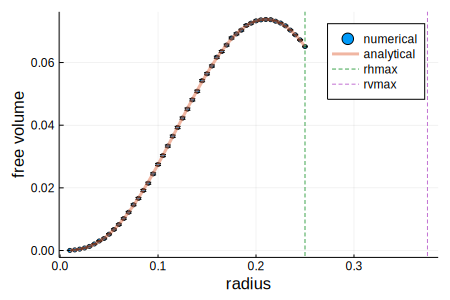

In [39]:
scatter(rs, numerical_V_data, yerror = 2 .* sigma_V_data, markersize=2, lab="numerical", xlabel="radius", ylabel ="free volume")

plot!(rs, exact_V_data, lab="analytical", lw=3, alpha=0.5, size=(450, 300))
vline!([rhmax], ls=:dash, label="rhmax")
vline!([rvmax], ls=:dash, label="rvmax")

In [16]:
maximum(exact_V_data)/maximum(numerical_V_data) # Worst error.

1.0004527105789944

In [17]:
savefig("FreeVolume3D01.pdf")

## MC calculation of hopping areas

In [40]:
""" Explore hops along the first (a or h1) dimension """ 

function area_horiz_hop3D(a, b, c, r)
    vnegbc=16*pi*b*c*r^2-64/3*(b+c)*r^3+8*r^4
    vposbc=16*b^2*c^2
    #result= 2 *sr2* a* (vposbc-vnegbc)
    # dado que los volumenes son pequeños, primero exploramos lo negativo
    result= 2 *sr2* a* vnegbc
    return result
end



area_horiz_hop3D (generic function with 1 method)

In [20]:
rs_A, numerical_A_hop_data, sigma_A_hop_data, exact_A_hop_data = run_MC(MC_horiz_hop_area3D, area_horiz_hop3D, rhmax, 10^7)

0.01 0.015 0.02 0.025 0.03 0.035 0.04 0.045 0.05 0.055 0.06 0.065 0.07 0.075 0.08 0.085 0.09 0.095 0.1 0.105 0.11 0.115 0.12 0.125 0.13 0.135 0.14 0.145 0.15 0.155 0.16 0.165 0.17 0.175 0.18 0.185 0.19 0.195 0.2 0.205 0.21 0.215 0.22 0.225 0.23 0.235 0.24 0.245 0.25 

([0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055  …  0.205, 0.21, 0.215, 0.22, 0.225, 0.23, 0.235, 0.24, 0.245, 0.25], [0.002196852305087999, 0.007653895974474747, 0.011763164410675197, 0.017566164109374994, 0.022621114570751995, 0.03014922304437613, 0.03885661982146559, 0.046248943314646775, 0.05513258519999997, 0.06409464271941523  …  0.20509721467423472, 0.2020544213815297, 0.19756489371515823, 0.1928081681913857, 0.18473640732421875, 0.17740777471672323, 0.17287026231128894, 0.1627484121888768, 0.15918476408826618, 0.15031974999999997], [0.0005672244006934339, 0.0010320482845152775, 0.001246887385062296, 0.0014846014413105555, 0.0016410925466084512, 0.0018450778538121417, 0.0020394066122824085, 0.0021657558245355775, 0.00230112359984158, 0.0024138588048990763  …  0.0016256427794095977, 0.0015516638229352868, 0.0014746870223862265, 0.0013994048729485272, 0.0013150625421444325, 0.0012364699868188166, 0.0011703286463554546, 0.0010881636180807453, 0.0010305478418072864

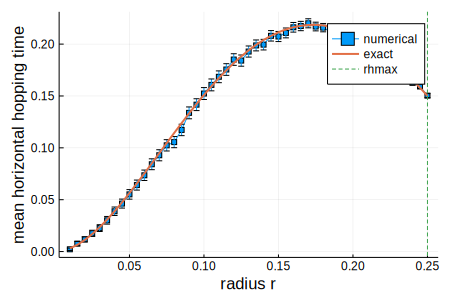

In [21]:
plot(rs_A, numerical_A_hop_data, yerr=2 .* sigma_A_hop_data, m=:square, markersize=2, lab="numerical")
plot!(rs_A, exact_A_hop_data, lw=2, lab="exact", size=(450, 300))
xlabel!("radius r")
ylabel!("mean horizontal hopping time")
vline!([rhmax], label="rhmax", ls=:dash)

In [22]:
savefig("figures/AreaHop01.pdf")

SystemError: SystemError: opening file "/home/karel/postdocSanders/TwoDiskinaRectangle/julia_code/figures/AreaHop01.pdf": No such file or directory

In [23]:
# plot(rs, exact_A_data/2 ./ num_A_data, m=:square)


## Area for disc collisions

In [1]:
""" Analytical Area for Collitions 3D """

function area_col3D(a,b,c,r)
    # asumiendo r<rhopmax
    result= 64 * (2 * π * r^2 * a * b *c 
                - r^3 * π * (a*b+b*c+c*a)
                + 4 * r ^4 / 3* (a+b+c)
                -r^5/2)
end

area_col3D (generic function with 1 method)

In [42]:
rs_C, num_C_data, sigma_C_data, exact_C_data = run_MC(MC_collision_area3D, area_col3D, rhmax, 10^7)

0.01 0.015 0.02 0.025 0.03 0.035 0.04 0.045 0.05 0.055 0.06 0.065 0.07 0.075 0.08 0.085 0.09 0.095 0.1 0.105 0.11 0.115 0.12 0.125 0.13 0.135 0.14 0.145 0.15 0.155 0.16 0.165 0.17 0.175 0.18 0.185 0.19 0.195 0.2 0.205 0.21 0.215 0.22 0.225 0.23 0.235 0.24 0.245 0.25 

([0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055  …  0.205, 0.21, 0.215, 0.22, 0.225, 0.23, 0.235, 0.24, 0.245, 0.25], [0.007908668298316797, 0.02282252617843379, 0.032249574339379194, 0.04767958829687499, 0.0688158116941824, 0.08446299189960056, 0.10704302981119997, 0.13286428890830546, 0.15367967999999996, 0.17437379395154382  …  0.3925136349800009, 0.38338776079718423, 0.3625331237876503, 0.3411464100093954, 0.32163551191406253, 0.3019662707503104, 0.2833766901550356, 0.2652509629366272, 0.23876042715116907, 0.21909124999999996], [0.0015220218689212038, 0.002520316061408177, 0.0029197214619054736, 0.0034590080313960376, 0.004047930429324638, 0.004367395664553396, 0.004786990144265996, 0.005191267329845391, 0.005433179852694321, 0.0056305534801437546  …  0.003180552052475527, 0.003022849011724706, 0.002825309077196886, 0.0026327741166213142, 0.0024542716467508443, 0.002281697381982718, 0.002119484244293623, 0.001965030019494285, 0.0017854311036475973, 0.0016367857877

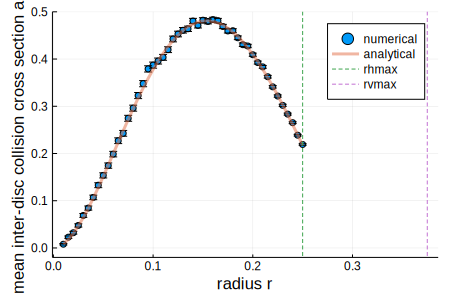

In [45]:
scatter(rs_C, num_C_data, yerror=sigma_C_data, markersize=3, lab="numerical", ylim=(-0.02,0.5))
plot!(rs_C, exact_C_data, lab="analytical", lw=3, alpha=0.5, size=(450, 300))
xlabel!("radius r")
ylabel!("mean inter-disc collision cross section area")
vline!([rhmax], label="rhmax", ls=:dash)
vline!([rvmax], label="rvmax", ls=:dash)

In [21]:
savefig("figures/AreaCol01.pdf")

In [22]:
# plot(rs, exact_C_data ./ num_C_data, m=:square)

## Area for wall collisions

In [119]:
area_wall_free(a, b, r) = 8*a*b^2 - 4*π*b*r^2 + 16/3*r^3 #perfect but needs generalization

exprpos_wall(a, b, r) = 8*a*b^2
exprcircular_wall(a, b, r, θ) = 8*b*r^2*θ + 16/3*r^3*cos(θ) #sector

# "upper triangle"
a_wall_uppt(a, b, r) = 8/3*b^2*sqrt(r^2 - b^2)
a_wall_lowt(a, b, r) = a_wall_uppt(b, a, r)

function area_wall(a, b, r)
    if (r < rhmax)
        result = area_wall_free(a, b, r)
        
    elseif (rhmax <= r) && (r < rvmax)
         α = asin(b / r)
        
         negative = exprcircular_wall(a, b, r, α) - exprcircular_wall(a, b, r, 0) + a_wall_uppt(a, b, r)
         result = exprpos_wall(a, b, r) - negative  # delete factor of 2 accounting for volume splitting
    else
        α = asin(b / r)
        β = acos(a / r)

        negative = 0 # (exprcircular_wall(a,b,r,α)-exprcircular_wall(a,b,r,β))+a_wall_uppt(a,b,r)+a_wall_lowt(a,b,r)
        result = exprpos_wall(a, b, r) - negative  # delete factor of 4 accounting for volume splitting
    end
    
    return result
end

area_wall (generic function with 1 method)

In [117]:
rs_W, num_W_data, sigma_W_data, exact_W_data = run_MC(MC_wall_area, area_wall, rmax, 10^7)

0.01 0.015 0.02 0.025 0.03 0.035 0.04 0.045000000000000005 0.05 0.055 0.060000000000000005 0.065 0.06999999999999999 0.075 0.08 0.08499999999999999 0.09 0.095 0.09999999999999999 0.105 0.11 0.11499999999999999 0.12 0.125 0.13 0.135 0.14 0.14500000000000002 0.15000000000000002 0.155 0.16 0.165 0.17 0.17500000000000002 0.18000000000000002 0.18500000000000003 0.19 0.195 0.2 0.20500000000000002 0.21000000000000002 0.21500000000000002 0.22 0.225 0.23 0.23500000000000001 0.24000000000000002 0.24500000000000002 0.25 0.255 0.26 0.265 0.27 0.275 0.28 0.28500000000000003 0.29000000000000004 0.29500000000000004 0.3 0.305 0.31 0.315 0.32 0.325 0.33 0.335 0.34 0.34500000000000003 0.35000000000000003 0.35500000000000004 0.36000000000000004 0.365 0.37 0.375 0.38 

([0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055  …  0.335, 0.34, 0.345, 0.35, 0.355, 0.36, 0.365, 0.37, 0.375, 0.38], [1.42313, 1.37708, 1.34646, 1.31497, 1.26791, 1.23132, 1.20014, 1.16034, 1.12624, 1.08369  …  0.0190554, 0.0154852, 0.0127805, 0.0100685, 0.00787302, 0.005285, 0.00336703, 0.00172973, 0.0003375, 1.26167e-5], [0.0172967, 0.0167271, 0.0162582, 0.0157906, 0.0152364, 0.0147521, 0.0143067, 0.0138166, 0.013367, 0.0128737  …  0.000378047, 0.000326493, 0.000283842, 0.000240799, 0.000203265, 0.000158764, 0.000120632, 8.218e-5, 3.44458e-5, 6.30835e-6], [1.42078, 1.38177, 1.34317, 1.30498, 1.26721, 1.22988, 1.19298, 1.15653, 1.12053, 1.08499  …  0.0189374, 0.0156513, 0.0126712, 0.00998294, 0.00757265, 0.00542663, 0.00353129, 0.00187319, 0.046875, 0.042624])

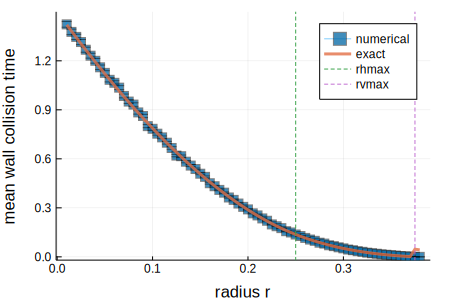

In [135]:
plot(rs_W, num_W_data, yerror=sigma_W_data, m=:square, lab="numerical", ylim=(-0.02,1.5), alpha=0.5)
plot!(rs_W, exact_W_data, lab="exact", lw=3, size=(450, 300), alpha=0.8)
xlabel!("radius r")
ylabel!("mean wall collision time")
vline!([rhmax], label="rhmax", ls=:dash)
vline!([rvmax], label="rvmax", ls=:dash)

In [136]:
savefig("figures/AreaWall01.pdf")

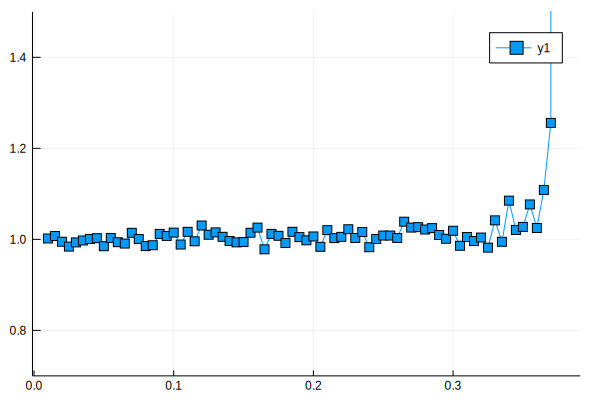

In [63]:
# plot(rs, exact_W_data ./ num_W_data, m=:square, ylim=(0.7,1.5))